In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [42]:
def simple_cubic_lattice(a, size):
    """
    Create a simple cubic lattice with lattice constant "a." "size" is the number of unit cells along each axis.
    """

    #x, y, and z unit vectors
    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    # List of positions in a single unit cell for FCC structure
    sc_positions = a*np.array([
        [0, 0, 0], 
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in sc_positions:
                    R.append(l*x + m*y + n*z + pos)

    return np.array(R)

    
def BCC_lattice(a, size):
    """
    Create a BCC lattice with lattice constant "a." "size" is the number of unit cells along each axis.
    """

    #x, y, and z unit vectors
    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    # BCC primitive vectors
    bcc_positions = (a/2)*np.array([
        [0, 0, 0],
        [1, 1, 1] 
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in bcc_positions:
                    R.append(l*x + m*y + n*z + pos)

    return np.array(R)
    

def FCC_lattice(a, size):
    """
    Create a FCC lattice with lattice constant "a." "size" is the number of unit cells along each axis.
    """

    #x, y, and z unit vectors
    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    #FCC primitive vectors 
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)

    return np.array(R)
    

def diamond_lattice(a, size):
    """
    Create a diamond lattice with lattice constant "a." "size" is the number of unit cells along each axis.
    """

    #x, y, and z unit vectors
    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)


def build_lattice(lattice_type, a, size):
    """
    Dispatcher function. Given a string, it will build that lattice type.
    """
    if lattice_type == "SC":
        coords = simple_cubic_lattice(a, size)
        nn_dist = a
        return coords, nn_dist
    elif lattice_type == "BCC":
        coords = BCC_lattice(a, size)
        nn_dist = a * (np.sqrt(3) / 2)
        return coords, nn_dist
    elif lattice_type == "FCC":
        coords = FCC_lattice(a, size)
        nn_dist = a * (1 / np.sqrt(2))
        return coords, nn_dist
    elif lattice_type == "diamond":
        coords = diamond_lattice(a, size)
        nn_dist = a * (np.sqrt(3) / 4)
        return coords, nn_dist
    else:
        raise ValueError(f"Unknown lattice type: {lattice_type}")
        


def dilute_lattice(lattice, prob):
    """
    dilute lattice by occupying sites with probability "prob."
    """

    #if prob = 1, all sites occupied so return lattice
    if prob == 1:
        return lattice

    N = len(lattice)
    k = int(N * prob) #number of sites to keep

    chosen_idx = random.sample(range(N), k) #choose k lattice sites
    
    return lattice[chosen_idx]


# def get_nn_distance(a, lattice):
#     """
#     get nearest neighbor distance for lattice with lattice constant "a."
#     """
#     from scipy.spatial import KDTree

#     tree = KDTree(lattice)
#     dists, idxs = tree.query(lattice, k=2)
#     nn_distances = dists[:, 1]
#     return np.min(nn_distances)
    

def calculate_W(a, size, lattice, nn_dist, A, alpha, nearest_neighbor=False):
    """
    calculate hopping/jumping rate matrix between sites. Strength given by A,
    for long-range coupling, power-law exponent is given by alpha.
    """

    N = lattice.shape[0] #total number of sites
    W = np.zeros((N, N)) #initialize hopping matrix
    box_size = a * (2*size + 1)

    #loop through all site pairs without double counting
    for i in range(N - 1):
        for j in range(i + 1, N):
            diff = lattice[i] - lattice[j]
            diff = diff - box_size * np.round(diff / box_size) #periodic boundary conditions
            dist = np.linalg.norm(diff)

            if nearest_neighbor:
                if np.isclose(dist, nn_dist, atol=1e-6):
                    wij = A
                else:
                    wij = 0
            else:
                wij = A / (dist**alpha)
            
            W[i, j] = wij
            W[j, i] = wij #symmetry

    #on diagonal elements should be negative of total leaving that site for probability conservation
    W = W - np.diag(np.sum(W, axis=0)) 
    
    return W


# #vectorized calculation for better speed
# def calculate_W(a, size, lattice, nn_dist, A, alpha, nearest_neighbor=False):
#     """
#     calculate hopping/jumping rate matrix between sites. Strength given by A,
#     for long-range coupling, power-law exponent is given by alpha.
#     """

#     N = lattice.shape[0] #total number of sites
#     box_size = a * (2*size + 1)

#     diff = lattice[:, None, :] - lattice[None, :, :]
#     diff = diff - box_size * np.round(diff / box_size)
#     dist = np.linalg.norm(diff, axis=2)

#     np.fill_diagonal(dist, np.inf)

#     if nearest_neighbor:
#         mask = np.isclose(dist, nn_dist, atol=1e-6)
#         W_off = np.zeros_like(dist)
#         W_off[mask] = A
#     else:
#         with np.errstate(over='ignore', divide='ignore', invalid='ignore'):
#             W_off = A / (dist**alpha)
    
#     np.fill_diagonal(W_off, 0)
#     col_sums = np.sum(W_off, axis=0)
#     W = W_off - np.diag(col_sums)
    
#     return W

In [43]:
def periodic_distance(r1, r2, size, a):
    """
    calculate distance between two points r1 and r2 with periodic boundary conditions
    """
    
    box_size = a * (2*size + 1)
    diff = r2 - r1
    diff_wrapped = diff - box_size * np.round(diff / box_size)
    dist = np.linalg.norm(diff_wrapped)
    return dist


def pad(data):
    """
    pad data with np.nan (for data that is a list of arrays of different sizes).
    """
    
    x = len(data)
    y = max(len(arr) for arr in data)
    padded_data = np.full((x, y), np.nan)
    for i in range(x):
        padded_data[i, :len(data[i])] = data[i]
    return padded_data


def contribution_threshold(data, cutoff_fraction):
    """
    Find the time index where certain fraction of the trajectories contribute.
    Basically, some random walkers will get stuck at a site for a long time and overshoot t_max
    by a lot. So time points will only have a few trajectories contributing to the ensemble average, 
    making it not a good statistical average/too small of a sample size.
    """
    
    data_arr = np.array(data)
    n_trajectories = data_arr.shape[0]
    min_required = int(cutoff_fraction * n_trajectories)  
    valid_counts = np.sum(~np.isnan(data), axis=0)
    cutoff_idx = np.where(valid_counts < min_required)[0]
    if len(cutoff_idx) > 0:
        last_valid_idx = cutoff_idx[0]
    else:
        last_valid_idx = data_arr.shape[1]
        
    return last_valid_idx
    

def gillespie(size, a, W, lattice, t_max):
    """
    Simulate random walk for one walker using gillespie algorithm.
    Randomly start on a site and sample next time step from an exponential probability distribution 
    with mean given by total escape rate from that site. Then randomly jump to next site based on probability
    proportional to the hopping rate to that site. Then collect statistics.
    """
    
    N = W.shape[0] #total number of sites
    site = np.random.randint(N) #start on a random site
    time = 0

    sites = [site]
    wait_times = []
    times = [0]

    #gillespie loop
    while time < t_max:
        rates = W[:, site] #vector of hopping rate to each site
        total_rate = -W[site, site] #total hopping rate from site

        tau = np.random.exponential(1 / total_rate) #randomly sample time to next hop from an exponential distirbution (gillespie)
        time += tau

        probs = rates.copy()
        probs[site] = 0 #no self-hopping
        probs /= total_rate #normalize
        next_site = np.random.choice(N, p=probs) #randomly choose what site to jump to

        #collect data
        wait_times.append(tau)
        sites.append(next_site)
        times.append(time)

        site = next_site

    #calculate all jump lengths and squared displacements (using periodic boundary conditions).
    jump_lengths = [periodic_distance(lattice[sites[i+1]], lattice[sites[i]], size, a) for i in range(len(sites) - 1)]
    squared_displacements = [periodic_distance(lattice[sites[i]], lattice[sites[0]], size, a)**2 for i in range(len(sites))]

    #calculate number of distinct visited sites
    visited = set()
    distinct_sites = []
    for site in sites:
        visited.add(site)
        distinct_sites.append(len(visited))

    return wait_times, jump_lengths, times, squared_displacements, distinct_sites, sites


def ensemble_average(size, a, W, lattice, t_max, n_trajectories):
    """
    ensemble average over "n_trajectories" different random walkers on the same lattice
    """
    from tqdm import tqdm

    all_wait_times = []
    all_jump_lengths = []
    max_steps = 0
    all_times = []
    all_squared_displacements = []
    all_distinct_sites = []
    all_sites = []

    #loop over n_trajectories of random walkers and collect statistics
    for _ in range(n_trajectories):
        wait_times, jump_lengths, times, sq_disp, distinct_sites, sites = gillespie(size, a, W, lattice, t_max)

        all_wait_times.extend(wait_times)
        all_jump_lengths.extend(jump_lengths)
        all_times.append(times)
        all_squared_displacements.append(sq_disp)
        all_distinct_sites.append(distinct_sites)
        all_sites.append(sites)

    #carefully calculate ensemble averages, nontrivial since each random walker hops at different time points

    #msd_vs_steps
    padded_disp = pad(all_squared_displacements) #pad
    msd_vs_steps = np.nanmean(padded_disp, axis=0) #average with nan
    last_valid_idx = contribution_threshold(padded_disp, 0.8) 
    msd_vs_steps = msd_vs_steps[:last_valid_idx] #only keep points where 80% of trajectories contribute

    #msd_vs_time
    from scipy.interpolate import interp1d
    t_bins = np.linspace(0, t_max, last_valid_idx)
    all_interp_disp = []
    for times, sq_disp in zip(all_times, all_squared_displacements):
        times = np.array(times)
        sq_disp = np.array(sq_disp)
        valid_times_mask = times <= t_max
        f = interp1d(times[valid_times_mask], sq_disp[valid_times_mask], kind='previous', bounds_error=False, fill_value=np.nan)
        interp_disp = f(t_bins)
        all_interp_disp.append(interp_disp)

    msd_vs_time = np.nanmean(all_interp_disp, axis=0)
    last_valid_idx = contribution_threshold(all_interp_disp, 0.8)
    t_bins = t_bins[:last_valid_idx]
    msd_vs_time = msd_vs_time[:last_valid_idx]

    #distinct sites visited
    padded_distinct_sites = pad(all_distinct_sites)
    distinct_sites_vs_steps = np.nanmean(padded_distinct_sites, axis=0)
    last_valid_idx = contribution_threshold(padded_distinct_sites, 0.8)
    distinct_sites_vs_steps = distinct_sites_vs_steps[:last_valid_idx]

    return all_wait_times, all_jump_lengths, msd_vs_steps, t_bins, msd_vs_time, distinct_sites_vs_steps, all_times, all_sites


def config_average(size, a, lattice_type, prob, nearest_neighbor, A, alpha, t_max, n_trajectories, n_configs):
    """
    For dilute lattices/networks, each realization will be random and different from the next.
    This function will ensemble average the gillespie algorithm over n_configs different lattice realizations
    (Monte Carlo). 
    """
    from tqdm import tqdm

    all_wait_times = []
    all_jump_lengths = []
    all_msd_vs_steps = []
    all_t_bins = []
    all_msd_vs_time = []
    all_distinct_sites = []
    all_sites = []
    all_times = []

    #loop over different configurations (Monte Carlo)
    for _ in tqdm(range(n_configs), desc="configurations"):
        
        #reconstruct lattice every iteration and calculate W each time
        lattice, nn_dist = build_lattice(lattice_type, a, size)
        diluted_lattice = dilute_lattice(lattice, prob)
        W = calculate_W(a, size, diluted_lattice, nn_dist, A, alpha, nearest_neighbor)

        wait_times, jump_lengths, msd_vs_steps, t_bins, msd_vs_time, distinct_sites, times, sites = ensemble_average(
           size, a, W, diluted_lattice, t_max, n_trajectories 
        )

        all_wait_times.extend(wait_times)
        all_jump_lengths.extend(jump_lengths)
        all_msd_vs_steps.append(msd_vs_steps)
        all_t_bins.append(t_bins)
        all_msd_vs_time.append(msd_vs_time)
        all_distinct_sites.append(distinct_sites)
        all_sites.append(sites)
        all_times.append(times)

    #calculate configurational averages

    #msd_vs_steps
    padded_msd = pad(all_msd_vs_steps)
    msd_vs_steps_avg = np.nanmean(padded_msd, axis=0)
    last_valid_idx = contribution_threshold(padded_msd, 0.8)
    msd_vs_steps_avg = msd_vs_steps_avg[:last_valid_idx]

    #msd_vs_time
    padded_t_bins = pad(all_t_bins)
    t_bins_avg = np.nanmean(padded_t_bins, axis=0)
    padded_time_disp = pad(all_msd_vs_time)
    msd_vs_time_avg = np.nanmean(padded_time_disp, axis=0)
    last_valid_idx = contribution_threshold(padded_time_disp, 0.8)
    t_bins_avg = t_bins_avg[:last_valid_idx]
    msd_vs_time_avg = msd_vs_time_avg[:last_valid_idx]

    #distinct sites visited
    padded_distinct_sites = pad(all_distinct_sites)
    distinct_sites_avg = np.nanmean(padded_distinct_sites, axis=0)
    last_valid_idx = contribution_threshold(padded_distinct_sites, 0.8)
    distinct_sites_avg = distinct_sites_avg[:last_valid_idx]

    return all_wait_times, all_jump_lengths, msd_vs_steps_avg, t_bins_avg, msd_vs_time_avg, \
           distinct_sites_avg, all_times, all_sites

In [44]:
def run_simulation(
    size, #natural number
    a, #float
    lattice_type, #string
    diluted, #True/False
    prob, #float
    nearest_neighbor, #True/False
    A, #float
    alpha, #float
    t_max, #float
    n_trajectories, #natural number
    n_configs, #natural number
    savefile=None 
):
    """
    High-level function. Setup lattice, dilute lattice if necessary, contruct hopping rate matrix, 
    and run random walk simulations. 
    
    Parameters:
    size (natural number): number of unit cells along each axis
    a (float): lattice constant
    lattice_type (string): "SC", "BCC", "FCC", or "diamond"
    diluted (True/False): Is the lattice 100% concentration? T/F
    prob (float): If diluted, what is the concentration? Must be between 0 and 1.
    nearest_neighbor (True/False): Is the hopping only between nearest neighbors? T/F
    A (float): Hopping rate = A / (r**alpha), r is distance between sites.
    alpha (float): Hopping rate = A / (r**alpha), r is distance between sites.
    t_max (float): Maximum time for gilllespie algorithm to run for each random walker.
    n_trajectories (natural number): Number of ensemble averages. 
    n_configs (natural number): Number of configurational averages/Monte Carlo trajectories.
    savefile=None (string (or None)): Filename for saving

    Returns:
    Dictionary of results:
        'wait_times': list of waiting times from all random walkers,
        'jump_lengths': list of jump lengths from all random walkers,
        'msd_vs_steps': 1D array of mean squared displacement vs. step number,
        't_bins': 1D array of time,
        'msd_vs_time': 1D array of mean squared displacement vs. time,
        'distinct_sites_vs_steps': 1D array of number of distinct sites visited vs. step number,
        'all_times': list of all the different time points where a jump happened,
        'all_sites': list of all the different site indices that were jumped to
    """

    #Only need to configuartional average if the lattice is diluted. Otherwise, every lattice configuration is identical
    #so just need to construct the lattice once
    if diluted:
        all_wait_times, all_jump_lengths, msd_vs_steps, t_bins, msd_vs_time, \
        distinct_sites_vs_steps, all_times, all_sites = config_average(
            size, a, lattice_type, prob, nearest_neighbor, A, alpha, t_max, n_trajectories, n_configs)
        results = {
            'wait_times': all_wait_times,
            'jump_lengths': all_jump_lengths,
            'msd_vs_steps': msd_vs_steps,
            't_bins': t_bins,
            'msd_vs_time': msd_vs_time,
            'distinct_sites_vs_steps': distinct_sites_vs_steps,
            'all_times': all_times,
            'all_sites': all_sites
                  }
    else:
        lattice, nn_dist = build_lattice(lattice_type, a, size) 
        W = calculate_W(a, size, lattice, nn_dist, A, alpha, nearest_neighbor)
        
        all_wait_times, all_jump_lengths, msd_vs_steps, t_bins, msd_vs_time, \
        distinct_sites_vs_steps, all_times, all_sites = ensemble_average(
            size, a, W, lattice, t_max, n_trajectories)
        results = {
            'wait_times': all_wait_times,
            'jump_lengths': all_jump_lengths,
            'msd_vs_steps': msd_vs_steps,
            't_bins': t_bins,
            'msd_vs_time': msd_vs_time,
            'distinct_sites_vs_steps': distinct_sites_vs_steps,
            'all_times': all_times,
            'all_sites': all_sites
                  }

    if savefile is not None:
        np.savez(
            savefile,
            results=results,
            size=size,
            a=a,
            lattice_type=lattice_type,
            diluted=diluted,
            prob=prob,
            nearest_neighbor=nearest_neighbor, 
            A=A,
            alpha=alpha,
            t_max=t_max,
            n_trajectories=n_trajectories,
            n_configs=n_configs, 
        )

    return results

In [45]:
results = run_simulation(
    size=10,
    a=3.57,
    lattice_type="diamond",
    diluted=True,
    prob=1.1e-2,
    nearest_neighbor=False, 
    A=1e6,
    alpha=6,
    t_max=1,
    n_trajectories=100,
    n_configs=5, 
    savefile=None
)

C:\Users\coope\AppData\Local\Temp\ipykernel_26048\4090433646.py:142: RuntimeWarning: Mean of empty slice00:00<?, ?it/s]
  msd_vs_time = np.nanmean(all_interp_disp, axis=0)
configurations: 100%|████████████████████████████████████████████████████████████████████| 5/5 [05:19<00:00, 63.89s/it]


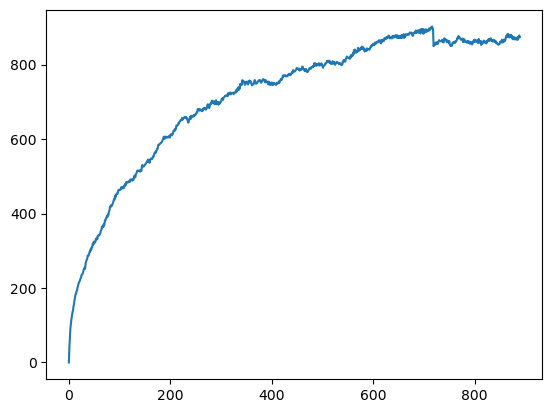

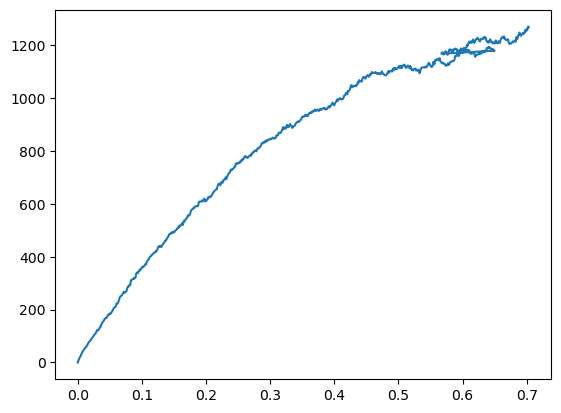

In [46]:
msd_vs_steps = results['msd_vs_steps']
t_bins = results['t_bins']
msd_vs_time = results['msd_vs_time']

n_steps = np.arange(0, len(msd_vs_steps))
plt.figure()
plt.plot(n_steps, msd_vs_steps)
plt.show()

plt.figure()
plt.plot(t_bins, msd_vs_time)
plt.show()